In [2]:
import torch
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    AutoModelForSequenceClassification
)
from trl import PPOTrainer, PPOConfig

# --- 1. Configuration (PPOConfig) ---
# On utilise les paramètres que vous avez listés (fusion des args d'entraînement et de PPO)
ppo_config = PPOConfig(
    # -- Paramètres Système & Sortie --
    output_dir="./ppo_gpt2_imdb",
    run_name="ppo-standard-trainer",
    logging_steps=10,
    save_strategy="steps",
    save_steps=100,

    # -- Hyperparamètres PPO (Le Cœur) --
    learning_rate=1.41e-5,
    num_ppo_epochs=4,               # Nombre de passes PPO sur chaque batch collecté
    num_mini_batches=1,             # Division du batch pour l'optimisation (économise VRAM)
    kl_coef=0.05,                   # Pénalité pour ne pas trop s'éloigner du modèle initial
    cliprange=0.2,
    vf_coef=0.1,                    # Importance de la loss du "Critic" (Value Model)

    # -- Paramètres de Génération --
    response_length=53,             # Longueur de la réponse générée (spécifique à cette config)
    temperature=0.7,

    # -- Gestion Batch & Dimensions --
    per_device_train_batch_size=4,  # Batch pour l'update des poids
    local_rollout_forward_batch_size=4, # Batch pour la collecte de données (génération)
    gradient_accumulation_steps=1,

    # -- Hardware --
    fp16=True,                      # ou bf16=True sur Ampere (RTX 30xx/40xx)
    seed=42,
)

# --- 2. Chargement des Modèles (Actor, Critic, Reward) ---
model_id = "gpt2"
reward_model_id = "lvwerra/distilbert-imdb"

# A. Tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left" # Crucial pour la génération

# B. Policy Model (Actor) -> Celui qu'on entraîne
# Note: C'est un simple CausalLM maintenant, plus besoin de "WithValueHead" ici
# car le Value Model est passé séparément.
policy_model = AutoModelForCausalLM.from_pretrained(model_id)

# C. Value Model (Critic) -> Prédit le score futur
# Il doit avoir la même architecture que le modèle (souvent) mais sortir 1 seule valeur (score).
value_model = AutoModelForSequenceClassification.from_pretrained(
    model_id,
    num_labels=1  # IMPORTANT: Sortie scalaire pour la Value Function
)
# Astuce : Souvent on initialise le Critic avec les poids de l'Actor pour accélérer la convergence,
# mais ici on part d'un checkpoint vierge pour l'exemple.
value_model.config.pad_token_id = tokenizer.pad_token_id


# D. Reward Model -> Juge la qualité
# Dans cette nouvelle API, on passe le MODÈLE, pas une fonction.
# Le Trainer s'occupera de faire l'inférence.
reward_model = AutoModelForSequenceClassification.from_pretrained(reward_model_id)

# E. Reference Model (Optionnel mais recommandé)
# Si None, le Trainer fait une copie du policy_model au démarrage.
# ref_model = AutoModelForCausalLM.from_pretrained(model_id)


# --- 3. Dataset ---
def build_dataset():
    ds = load_dataset("imdb", split="train")
    ds = ds.rename_columns({"text": "review"})
    ds = ds.filter(lambda x: len(x["review"]) > 200)

    def tokenize(sample):
        # On prépare juste l'input ("query")
        sample["input_ids"] = tokenizer.encode(sample["review"][:100]) # Prompt court
        # Le dataset doit retourner 'input_ids' pour que le collator fonctionne
        return sample

    ds = ds.map(tokenize, batched=False)
    return ds

train_dataset = build_dataset()

# --- 4. Initialisation du Trainer ---
trainer = PPOTrainer(
    args=ppo_config,
    processing_class=tokenizer,     # Remplace l'ancien argument 'tokenizer'
    model=policy_model,             # Actor
    ref_model=None,                 # Sera copié de model
    reward_model=reward_model,      # Juge (Freeze automatiquement géré par le trainer normalement)
    value_model=value_model,        # Critic
    train_dataset=train_dataset,
)

# --- 5. Entraînement ---
print("Lancement de l'entraînement PPO (Standard Loop)...")

# Cette simple ligne remplace toute la boucle for manuelle d'avant !
# Elle gère : Rollout -> Reward Calc -> Advantage Calc -> PPO Step
trainer.train()

# Sauvegarde
trainer.save_model("./ppo_final_model")
print("Terminé.")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/17.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/577 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/24895 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1168 > 1024). Running this sequence through the model will result in indexing errors


pytorch_model.bin:   0%|          | 0.00/548M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cuda:0


Démarrage de l'entraînement PPO (Version Stable)...


0it [00:00, ?it/s]You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.12/dist-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
6it [01:14, 12.32s/it]

Test réussi au step 5


10it [02:03, 12.27s/it]You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
11it [02:16, 12.29s/it]

Test réussi au step 10


16it [03:17, 12.24s/it]

Test réussi au step 15


21it [04:18, 12.26s/it]

Test réussi au step 20


26it [05:20, 12.44s/it]

Test réussi au step 25


31it [06:25, 12.75s/it]

Test réussi au step 30


36it [07:29, 12.80s/it]

Test réussi au step 35


41it [08:31, 12.46s/it]

Test réussi au step 40


46it [09:32, 12.28s/it]

Test réussi au step 45


51it [10:35, 12.42s/it]

Test réussi au step 50


56it [11:38, 12.63s/it]

Test réussi au step 55


61it [12:42, 12.74s/it]

Test réussi au step 60


66it [13:44, 12.43s/it]

Test réussi au step 65


71it [14:45, 12.33s/it]

Test réussi au step 70


76it [15:48, 12.52s/it]

Test réussi au step 75


81it [16:51, 12.65s/it]

Test réussi au step 80


86it [17:54, 12.71s/it]

Test réussi au step 85


91it [18:57, 12.53s/it]

Test réussi au step 90


96it [19:58, 12.28s/it]

Test réussi au step 95


101it [21:00, 12.25s/it]

Test réussi au step 100


103it [21:24, 12.28s/it]/usr/local/lib/python3.12/dist-packages/trl/trainer/ppo_trainer.py:1222: UserWarning: The average ratio of batch (20.50) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/trl/trainer/ppo_trainer.py:1222: UserWarning: The average ratio of batch (103.36) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/trl/trainer/ppo_trainer.py:1222: UserWarning: The average ratio of batch (11.66) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
106it [22:02, 12.57s/it]

Test réussi au step 105


111it [23:05, 12.63s/it]

Test réussi au step 110


116it [24:08, 12.61s/it]

Test réussi au step 115


121it [25:11, 12.52s/it]

Test réussi au step 120


126it [26:11, 12.10s/it]

Test réussi au step 125


131it [27:12, 12.11s/it]

Test réussi au step 130


/usr/local/lib/python3.12/dist-packages/trl/trainer/ppo_trainer.py:1222: UserWarning: The average ratio of batch (241.20) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/trl/trainer/ppo_trainer.py:1222: UserWarning: The average ratio of batch (1643.64) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/trl/trainer/ppo_trainer.py:1222: UserWarning: The average ratio of batch (3389.13) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
135it [28:00, 12.06s/it]/usr/local/lib/python3.12/dist-packages/trl/trainer/ppo_trainer.py:1222: UserWarning: The average ratio of batch (133.51) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
136it [28:12, 12.10s/it]

Test réussi au step 135


141it [29:13, 12.20s/it]

Test réussi au step 140


146it [30:14, 12.25s/it]

Test réussi au step 145


150it [31:05, 12.54s/it]/usr/local/lib/python3.12/dist-packages/trl/trainer/ppo_trainer.py:1222: UserWarning: The average ratio of batch (57.14) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
151it [31:17, 12.57s/it]

Test réussi au step 150


156it [32:20, 12.58s/it]

Test réussi au step 155


161it [33:23, 12.60s/it]

Test réussi au step 160


166it [34:25, 12.31s/it]

Test réussi au step 165


171it [35:26, 12.21s/it]

Test réussi au step 170


174it [36:02, 12.13s/it]/usr/local/lib/python3.12/dist-packages/trl/trainer/ppo_trainer.py:1222: UserWarning: The average ratio of batch (34.50) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
176it [36:26, 12.09s/it]

Test réussi au step 175


181it [37:28, 12.26s/it]

Test réussi au step 180


186it [38:31, 12.53s/it]

Test réussi au step 185


191it [39:34, 12.62s/it]

Test réussi au step 190


196it [40:36, 12.44s/it]

Test réussi au step 195


201it [41:38, 12.22s/it]

Test réussi au step 200


206it [42:38, 12.08s/it]

Test réussi au step 205


211it [43:39, 12.18s/it]

Test réussi au step 210


216it [44:40, 12.27s/it]

Test réussi au step 215


221it [45:42, 12.43s/it]

Test réussi au step 220


226it [46:45, 12.58s/it]

Test réussi au step 225


230it [47:36, 12.67s/it]/usr/local/lib/python3.12/dist-packages/trl/trainer/ppo_trainer.py:1222: UserWarning: The average ratio of batch (17.97) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
231it [47:48, 12.53s/it]

Test réussi au step 230


236it [48:50, 12.41s/it]

Test réussi au step 235


241it [49:51, 12.22s/it]

Test réussi au step 240


246it [50:53, 12.34s/it]

Test réussi au step 245


251it [51:54, 12.25s/it]

Test réussi au step 250


256it [52:56, 12.35s/it]

Test réussi au step 255


260it [53:46, 12.57s/it]/usr/local/lib/python3.12/dist-packages/trl/trainer/ppo_trainer.py:1222: UserWarning: The average ratio of batch (10.46) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/trl/trainer/ppo_trainer.py:1222: UserWarning: The average ratio of batch (14.05) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
261it [53:59, 12.69s/it]

Test réussi au step 260


266it [55:02, 12.61s/it]

Test réussi au step 265


271it [56:04, 12.41s/it]

Test réussi au step 270


276it [57:05, 12.12s/it]

Test réussi au step 275


281it [58:05, 12.05s/it]

Test réussi au step 280


286it [59:05, 11.99s/it]

Test réussi au step 285


291it [1:00:06, 12.18s/it]

Test réussi au step 290


296it [1:01:06, 12.12s/it]

Test réussi au step 295


301it [1:02:07, 12.16s/it]

Test réussi au step 300


306it [1:03:08, 12.16s/it]

Test réussi au step 305


/usr/local/lib/python3.12/dist-packages/trl/trainer/ppo_trainer.py:1222: UserWarning: The average ratio of batch (14.11) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
311it [1:04:11, 12.52s/it]

Test réussi au step 310


316it [1:05:14, 12.61s/it]

Test réussi au step 315


321it [1:06:16, 12.54s/it]

Test réussi au step 320


326it [1:07:18, 12.34s/it]

Test réussi au step 325


331it [1:08:19, 12.13s/it]

Test réussi au step 330


336it [1:09:19, 12.13s/it]

Test réussi au step 335


341it [1:10:20, 12.15s/it]

Test réussi au step 340


346it [1:11:20, 12.06s/it]

Test réussi au step 345


351it [1:12:21, 12.04s/it]

Test réussi au step 350


356it [1:13:21, 12.15s/it]

Test réussi au step 355


361it [1:14:22, 12.19s/it]

Test réussi au step 360


366it [1:15:26, 12.55s/it]

Test réussi au step 365


371it [1:16:29, 12.61s/it]

Test réussi au step 370


376it [1:17:31, 12.46s/it]

Test réussi au step 375


381it [1:18:33, 12.26s/it]

Test réussi au step 380


386it [1:19:33, 12.18s/it]

Test réussi au step 385


388it [1:19:57, 12.37s/it]


Courbe sauvegardée sous courbe_apprentissage_ppo.png


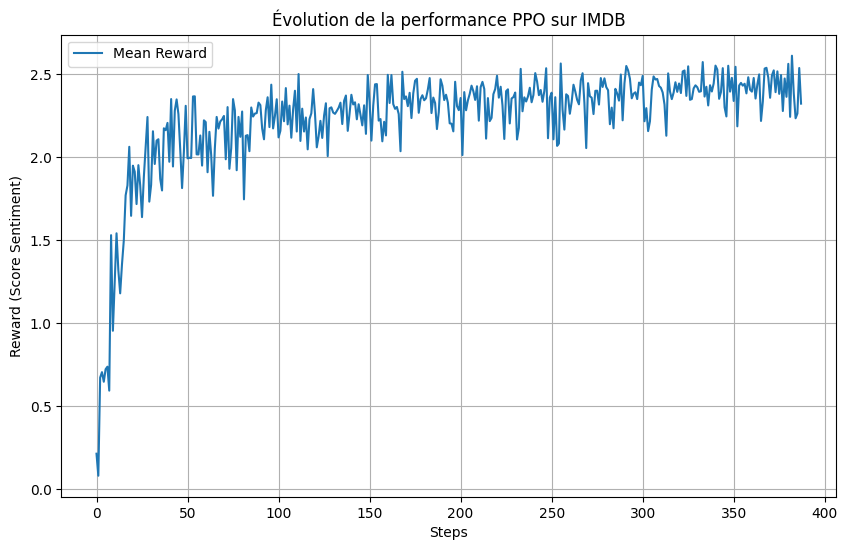

In [3]:
plt.figure(figsize=(10, 6))
plt.plot(history_rewards, label="Mean Reward")
plt.xlabel("Steps")
plt.ylabel("Reward (Score Sentiment)")
plt.title("Évolution de la performance PPO sur IMDB")
plt.legend()
plt.grid(True)
plt.savefig("courbe_apprentissage_ppo.png")
print("Courbe sauvegardée sous courbe_apprentissage_ppo.png")

In [7]:
import torch
from transformers import AutoTokenizer
from trl import AutoModelForCausalLMWithValueHead # Corrected import

# 1. Configuration
device = "cuda" if torch.cuda.is_available() else "cpu"
model_id = "lvwerra/gpt2-imdb" # Le modèle de base (avant PPO)
trained_model_path = "ppo_model_step_50" # Ton dossier sauvegardé (ajuste le nom)

# 2. Chargement des deux modèles
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token

print("Chargement du modèle de base...")
model_ref = AutoModelForCausalLMWithValueHead.from_pretrained(model_id).to(device)

print("Chargement du modèle PPO...")
# Assure-toi d'avoir sauvegardé le modèle dans ta boucle avec save_pretrained !
try:
    model_ppo = AutoModelForCausalLMWithValueHead.from_pretrained(trained_model_path).to(device)
except OSError:
    print(f"Erreur: Le dossier {trained_model_path} n'existe pas. Utilise le model_ref pour tester.")
    model_ppo = model_ref # Fallback pour tester le code

# 3. Le Test
prompts = [
    "The movie was really",
    "I went to the cinema and",
    "Honestly, this film is",
    "The acting was"
]

gen_kwargs = {
    "min_length": -1,
    "max_new_tokens": 20,
    "do_sample": True,
    "top_k": 0.0,
    "top_p": 1.0,
    "pad_token_id": tokenizer.eos_token_id
}

print("\n--- RÉSULTATS COMPARATIFS ---\n")

for prompt in prompts:
    inputs = tokenizer(prompt, return_tensors="pt").to(device)

    # Génération Base
    out_ref = model_ref.generate(inputs["input_ids"], **gen_kwargs)
    text_ref = tokenizer.decode(out_ref[0], skip_special_tokens=True)

    # Génération PPO
    out_ppo = model_ppo.generate(inputs["input_ids"], **gen_kwargs)
    text_ppo = tokenizer.decode(out_ppo[0], skip_special_tokens=True)

    print(f"PROMPT: {prompt}")
    print(f"🔴 Base : {text_ref}")
    print(f"🟢 PPO  : {text_ppo}")
    print("-" * 50)

Chargement du modèle de base...
Chargement du modèle PPO...


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Erreur: Le dossier ppo_model_step_50 n'existe pas. Utilise le model_ref pour tester.

--- RÉSULTATS COMPARATIFS ---

PROMPT: The movie was really
🔴 Base : The movie was really informative. A treasure of catching the evil in a tender moment. Tim Meadows, the lead writer on
🟢 PPO  : The movie was really weak and I wasn't aware of how that was supposed to be happening...beyond that the plot
--------------------------------------------------
PROMPT: I went to the cinema and
🔴 Base : I went to the cinema and just saw what was going on, I really want to hold few moments through this movie although I have
🟢 PPO  : I went to the cinema and it doesn't look like Jose was being clandestine with Dr. Mohr in appearance.<br /><
--------------------------------------------------
PROMPT: Honestly, this film is
🔴 Base : Honestly, this film is, hands down, practically the worst film I've ever seen: a strange formula for making a great
🟢 PPO  : Honestly, this film is far too entertaining to pass up.
----

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Calcul des scores...


/usr/local/lib/python3.12/dist-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id`

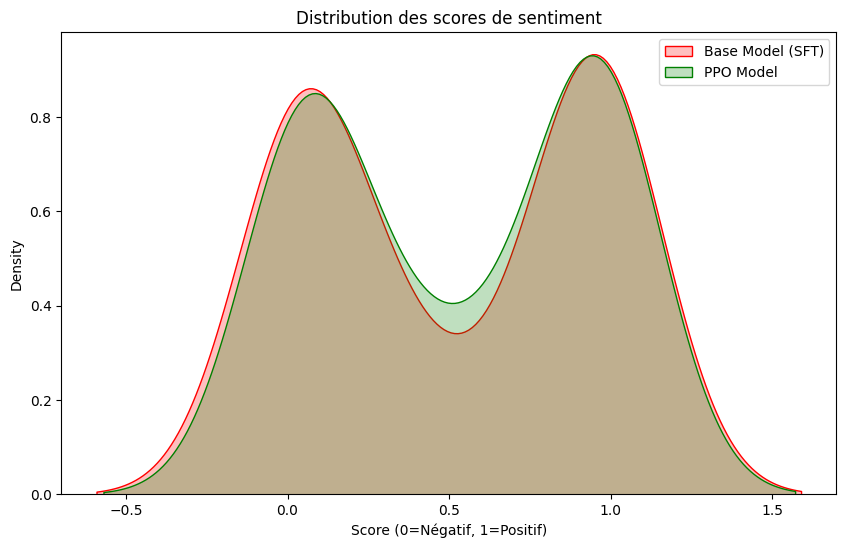

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns # pip install seaborn

def get_scores(model, tokenizer, reward_pipe, num_samples=50):
    scores = []
    # Génération de prompts factices ou prise dans le dataset
    dummy_prompts = ["The movie", "I felt", "This film"] * 20

    for prompt in dummy_prompts[:num_samples]:
        inputs = tokenizer(prompt, return_tensors="pt").to(device)
        out = model.generate(inputs["input_ids"], max_new_tokens=20, do_sample=True)
        text = tokenizer.decode(out[0], skip_special_tokens=True)

        # Scoring
        pipe_out = reward_pipe(text, **{"return_all_scores": True})
        score = pipe_out[0][1]["score"] # Score positif
        scores.append(score)
    return scores

print("Calcul des scores...")
scores_base = get_scores(model_ref, tokenizer, sentiment_pipe)
scores_ppo = get_scores(model_ppo, tokenizer, sentiment_pipe)

plt.figure(figsize=(10, 6))
sns.kdeplot(scores_base, fill=True, label="Base Model (SFT)", color="red")
sns.kdeplot(scores_ppo, fill=True, label="PPO Model", color="green")
plt.title("Distribution des scores de sentiment")
plt.xlabel("Score (0=Négatif, 1=Positif)")
plt.legend()
plt.savefig("histogramme_ppo.png")

In [ ]:
import torch
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM
from trl import RLOOTrainer, RLOOConfig # On importe RLOO au lieu de PPO
from trl.rewards import accuracy_reward
from datasets import load_dataset
import torch
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    pipeline
)
from trl import RLOOTrainer, RLOOConfig

# --- 1. Configuration (RLOOConfig) ---
model_name = "gpt2"  # On définit le nom ici pour l'utiliser plus bas


rloo_config = RLOOConfig(
    # --- 1. Paramètres Spécifiques RLOO (Le Coeur de l'algo) ---
    num_generations=4,              # C'est le "k" du papier. On génère 4 réponses par prompt.
    beta=0.05,                      # Pénalité KL (force le modèle à rester cohérent).
    temperature=1.0,                # Important ! Il faut de la diversité pour que RLOO apprenne.

    # --- 2. Hyperparamètres d'Entraînement ---
    learning_rate=5e-6,             # RLOO supporte un LR un peu plus bas que le SFT classique.
    num_train_epochs=1,             # UNE seule epoch. RLOO voit 4x plus de données via num_generations.
    per_device_train_batch_size=4,  # Attention : 4 prompts * 4 générations = 16 séquences en VRAM !
    gradient_accumulation_steps=4,  # Pour simuler un batch global plus grand (64).

    # --- 3. Gestion des Dimensions (Textes) ---
    max_prompt_length=128,          # On prend les 128 premiers tokens de la review IMDB.
    max_completion_length=64,       # Le modèle génère une suite de 64 tokens.

    # --- 4. Optimisation Système & Logs ---
    output_dir="./rloo_gpt2_imdb",  # Dossier de sauvegarde.
    fp16=True,                      # Utilise la demi-précision (Crucial pour la VRAM).
    gradient_checkpointing=True,    # Économise la mémoire au prix d'un peu de vitesse.
    logging_steps=10,               # Affiche les stats souvent.
    save_strategy="steps",
    save_steps=100,                 # Sauvegarde régulière.
    run_name="rloo-gpt2-exp1",      # Nom pour WandB ou les logs.
    seed=42                         # Pour la reproductibilité.
)

# --- 2. Chargement du Modèle et Tokenizer ---
# RLOO n'a besoin que du modèle causal (Actor). Pas de "Value Head" nécessaire.
model = AutoModelForCausalLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# CRITIQUE : Le padding doit être à GAUCHE pour la génération correcte avec GPT-2
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token

# --- 3. Préparation du Dataset ---
def build_dataset():
    ds = load_dataset("imdb", split="train")
    ds = ds.rename_columns({"text": "review"})

    # On garde les reviews assez longues
    ds = ds.filter(lambda x: len(x["review"]) > 200)

    # On prépare le format attendu par le Trainer : une colonne "prompt"
    def preprocess_function(examples):
        # On prend juste le début de la review comme prompt
        # Note: on ne tokenise pas tout de suite ici, le Trainer le fera.
        return {
            "prompt": [review[:200] for review in examples["review"]] # Coupe brute pour l'exemple
        }

    ds = ds.map(preprocess_function, batched=True)
    return ds

train_dataset = build_dataset()

# --- 4. Définition de la Reward Function ---
# Le Trainer attend une fonction callable(prompts, completions) -> list[float]
sentiment_pipe = pipeline(
    "sentiment-analysis",
    model="lvwerra/distilbert-imdb",
    device=0 if torch.cuda.is_available() else -1,
    tokenizer="lvwerra/distilbert-imdb" # Bonne pratique de spécifier le tokenizer du reward model
)

def reward_func(prompts, completions, **kwargs):
    """
    Calcule le sentiment (positif) des phrases générées.
    RLOOTrainer passe les textes décodés.
    """
    # On concatène prompt + completion pour l'analyse de sentiment complète
    inputs = [p + c for p, c in zip(prompts, completions)]

    pipe_outputs = sentiment_pipe(inputs, top_k=None, batch_size=16, truncation=True, max_length=512)
    rewards = []

    # On extrait le score du label "POSITIVE"
    for output in pipe_outputs:
        for label in output:
            if label['label'] == 'POSITIVE':
                rewards.append(label['score'])
                break

    return rewards

# --- 5. Initialisation du RLOOTrainer ---
# On utilise la signature moderne que vous avez fournie
trainer = RLOOTrainer(
    model=model,
    args=rloo_config,
    train_dataset=train_dataset,
    processing_class=tokenizer,     # Remplace l'argument 'tokenizer' dans les versions récentes
    reward_funcs=reward_func,       # La fonction de récompense est passée ici directement
)

# --- 6. Lancement de l'Entraînement ---
print("Démarrage de l'entraînement RLOO...")
# Le .train() gère la boucle de génération (k fois), le calcul du reward,
# le calcul de l'avantage (basé sur la moyenne des autres k-1 échantillons) et la backprop.
trainer.train()

# Sauvegarde
trainer.save_model(rloo_config.output_dir)
print("Entraînement terminé et modèle sauvegardé.")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/24895 [00:00<?, ? examples/s]

Device set to use cuda:0
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 50256}.


Démarrage de l'entraînement RLOO...


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 1


wandb: You chose 'Create a W&B account'
wandb: Create an account here: https://wandb.ai/authorize?signup=true&ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: charlene-krick (charlene-krick-ensta-paris) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
10,2200976691890371952640.000000
20,13209417467282272256.000000
30,13415906630587908096.000000
40,311095379728793.625000
50,2738362777880980717577948889088.000000
60,12978515834970417782271260395307008.000000
70,10568969535464725049123206619725824.000000
80,1995196297237562950552649728.000000
90,572354418528244174260535296.000000
100,89385107740406870637019136.000000


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
